<a href="https://colab.research.google.com/github/tc3oliver/StratLabFreq/blob/dev/MACD_Divergence_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 下載及 import

In [1]:
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib/
!./configure --prefix=/usr
!make
!sudo make install
!pip install TA-Lib
!pip install freqtrade

--2023-07-28 07:34:03--  http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
Resolving prdownloads.sourceforge.net (prdownloads.sourceforge.net)... 204.68.111.105
Connecting to prdownloads.sourceforge.net (prdownloads.sourceforge.net)|204.68.111.105|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-28 07:34:03--  http://downloads.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving downloads.sourceforge.net (downloads.sourceforge.net)... 204.68.111.105
Reusing existing connection to prdownloads.sourceforge.net:80.
HTTP request sent, awaiting response... 302 Found
Location: http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz [following]
--2023-07-28 07:34:03--  http://phoenixnap.dl.sourceforge.net/project/ta-lib/ta-lib/0.4.0/ta-lib-0.4.0-src.tar.gz
Resolving phoenixna

In [2]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/StratLabFreq')
os.listdir()

['ta-lib',
 'ta-lib-0.4.0-src.tar.gz',
 'data',
 'TaipeiSansTCBeta-Regular.ttf',
 'MACD_Divergence_Analysis.ipynb',
 'freqtrade.ipynb',
 '.ipynb_checkpoints']

In [3]:
!pip install mplfinance

In [4]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.font_manager as fm
import matplotlib as mpl
import numpy as np
import statistics
import talib
import talib.abstract as ta

# url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
# !curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
# url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
# !curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
# import talib
# import talib.abstract as ta

## 載入資料


In [5]:
dataframe = pd.read_json('./data/BTC_USDT-5m.json')
dataframe.columns=['date', 'open' , 'high', 'low', 'close', 'volume' ]
dataframe['date']=(pd.to_datetime(dataframe['date'],unit='ms'))

In [6]:
macd = ta.MACD(dataframe, fastperiod=13, slowperiod=34)
dataframe['macdhist'] = macd['macdhist']

## 隨機選取 count K棒

In [7]:
import random

count = 40

def get_random_count_values_dataframe(df):
    if len(df) < count:
        raise ValueError("DataFrame 中的資料數量不足 40 個")

    start_index = random.randint(0, len(df) - count)

    selected_values = df.iloc[start_index : start_index + count]

    selected_df = pd.DataFrame(selected_values)

    return selected_df

In [8]:
df = get_random_count_values_dataframe(dataframe)
df.head()

,date,open,high,low,close,volume,macdhist
8460,2017-09-15 19:55:00,3680.22,3703.13,3679.17,3702.66,5.381620,13.216851
8461,2017-09-15 20:00:00,3702.30,3705.71,3680.00,3680.00,2.875356,9.723894
8462,2017-09-15 20:05:00,3680.00,3700.00,3678.80,3699.27,2.078253,8.180993
8463,2017-09-15 20:10:00,3699.16,3710.00,3690.00,3710.00,2.407473,7.369178
8464,2017-09-15 20:15:00,3720.00,3720.00,3700.00,3700.00,2.331739,5.632965


## 尋找 macd 柱狀體波峰

In [20]:
# 尋找三個峰值且這些波峰連續升高
def find_peak_sequence(data):
        peaks_index = []
        wave = []

        for i in range(len(data)):
            if i == len(data) - 1:
                break
            d = abs(data[i])
            if len(wave) == 0 or d > wave[-1]:
                wave.append(d)
            else:
                if len(wave) > 1:
                    peaks_index.append(i-1)
                wave = [d]

        if len(wave) > 0:
            peaks_index.append(i)

        highlighted_points = [(index, data[index]) for index in peaks_index]

        temp = highlighted_points[-1]


        if len(highlighted_points) < 3:
            return False, []

        highlighted_points = highlighted_points[:-1]

        highlighted_points = sorted(
            highlighted_points, key=lambda x: abs(x[1]), reverse=True)[:2]
        highlighted_points = sorted(
            highlighted_points, key=lambda x: x[0], reverse=False)
        highlighted_points.append(temp)

        if len(highlighted_points) >= 3:
          # 波峰的差異
          percentage_difference = abs(abs(highlighted_points[-1][1]) - abs(highlighted_points[-3][1])) / (abs(highlighted_points[-3][1])) * 100

          # 波峰的步數
          step = abs(highlighted_points[-3][0] - highlighted_points[-1][0])

          if percentage_difference < 50:
            return False, []

          if step < count * 0.5:
            return False, []

          if abs(highlighted_points[-3][1]) > abs(highlighted_points[-2][1]) > abs(highlighted_points[-1][1]):
            return True, highlighted_points

        return False, []



## 多單

In [10]:
# 判斷低點持續降低
min_open_close = pd.Series.min(dataframe[['open', 'close']], axis=1)
dataframe['is_low_decreasing'] = min_open_close.rolling(window=count).apply(lambda x: (x[-1] < x[0]) & (x[-1] < min(x[:-1])), raw=True)

# 多單條件檢查 零軸以下的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_logn_wrapper(data):
  if data[-1] > 0:
    return False, []
  count = sum(1 for value in data if value < 0)
  if count < (len(data) / 2):
      return False, []
  return find_peak_sequence(data)

46.63574500669402 28
79.35241902285173 26
60.10693924517604 33
98.17760118402055 35
154.95506120016972 23
79.8431452491225 24
[0.6089622506508334, 0.8034978624711471, 1.0760973570338592, 0.7090572011626133, -0.15906500285083958, -0.7091726198448454, -1.4227889575797423, -1.037241564976445, -1.0400965797490622, -0.9658393395578182, -2.4041694982241557, -4.522216164785532, -5.734041178499523, -6.543738839425804, -6.724125714687469, -6.857081021121469, -6.150205710079304, -5.752450302421891, -4.707245597047903, -3.324515931518217, -2.79164857725252, -2.3702386579668904, -2.2882829074571625, -1.6351097709326297, -0.6454551105260755, -0.07546308618974784, 0.6016216377927854, 1.3165631087342682, 2.193845507408147, 2.593459164711673, 2.4673264443457565, 1.9137745530550987, 1.4635547609824417, 1.101395378397224, 0.7893746240570145, 0.6013474907856988, 0.17386055770751874, 0.13366497055324533, -0.0913484342959201, -1.3821718615774419]
[(15, -6.857081021121469), (29, 2.593459164711673), (39, -1.

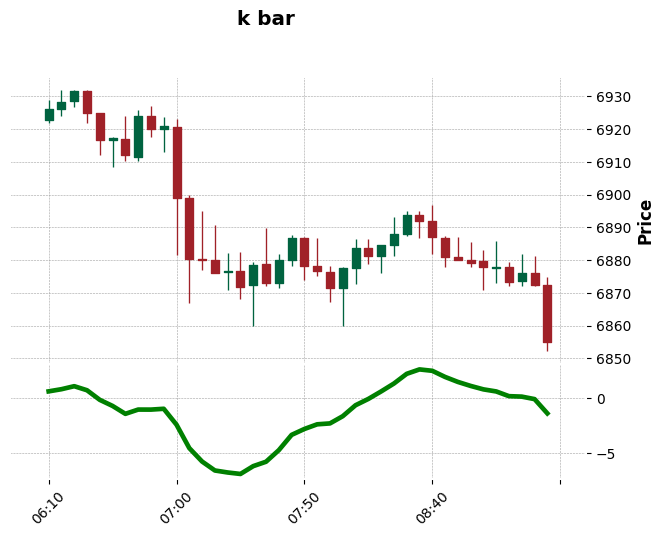

In [11]:
while True:

  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_logn_wrapper(data)


  if isfind:

    if df['is_low_decreasing'].values.tolist()[-1]:
      print(data)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

## 空單

In [12]:
# dataframe['is_high_decreasing'] = dataframe['high'].rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)
# 判斷高點持續提高
max_open_close = pd.Series.max(dataframe[['open', 'close']], axis=1)
dataframe['is_high_increase'] = max_open_close.rolling(window=count).apply(lambda x: (x[-1] > x[0]) & (x[-1] > max(x[:-1])), raw=True)

# 空單條件檢查 零軸以上的 MACD 柱狀體應該大於 windows 的一半
def find_peak_sequence_short_wrapper(data):
            if data[-1] < 0:
                return False, []
            if abs(statistics.mean(x for x in data[-3:-1])) > abs(data[-1]):
                return False, []
            count = sum(1 for value in data if value > 0)
            if count < (len(data) / 2):
                return False, []
            return find_peak_sequence([n for n in data if n > 0])

20.872551234824186 24
27.453294350582063 17
95.39673396677604 17
73.32779179718173 14
44.65881253892708 26
32.14271721475752 18
81.93478353891766 25
24.133614414482345 28
70.31146856068196 23
86.64380274727928 26
1.3486407608479831 10
15.334408200005988 24
0.43572986230629623 5
65.57657281433119 13
35.78756352646941 21
34.3399848289786 24
92.24366304139767 21
110.62338673606011 18
1000.1778729474078 14
46.192607289741986 14
250.57749366159476 11
877.2243854892178 11
43.726113116146855 27
61.30209596252653 23
27.792185465026364 19
281.4355710895676 10
82.41906365051439 31
                      date      open      high       low     close     volume  \
616681 2023-07-04 09:00:00  30930.75  30934.00  30890.00  30890.01  170.21179   
616682 2023-07-04 09:05:00  30890.01  30948.33  30867.68  30944.45  142.42476   
616683 2023-07-04 09:10:00  30944.45  31002.51  30944.44  31002.50  107.35429   
616684 2023-07-04 09:15:00  31002.51  31045.00  31002.50  31016.01  187.31840   
616685 2023-07-04

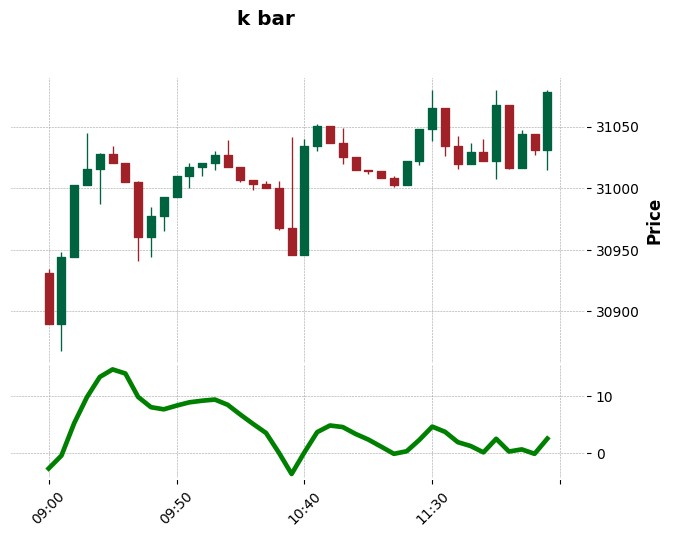

In [13]:
# 空單
while True:

  df = get_random_count_values_dataframe(dataframe[615796:])
  data = df['macdhist'].values.tolist()



  isfind, l = find_peak_sequence_short_wrapper(data)


  if isfind:
    if df['is_high_increase'].values.tolist()[-1]:
      print(df)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break

## 結合其他指標

In [15]:
import freqtrade.vendor.qtpylib.indicators as qtpylib

In [16]:
bollinger = qtpylib.bollinger_bands(qtpylib.typical_price(dataframe), window=20, stds=2)
dataframe['bb_lowerband'] = bollinger['lower']
dataframe['bb_middleband'] = bollinger['mid']
dataframe['bb_upperband'] = bollinger['upper']
dataframe['ema100'] = ta.EMA(dataframe, timeperiod=100)

In [17]:
dataframe

,date,open,high,low,close,volume,macdhist,is_low_decreasing,is_high_increase,bb_lowerband,bb_middleband,bb_upperband,ema100
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48,2.189061,NaN,NaN,NaN,NaN,4267.840000,NaN,NaN
1,2017-08-17 04:05:00,4261.48,4261.48,4261.48,4261.48,0.000000,NaN,NaN,NaN,4255.665602,4264.660000,4273.654398,NaN
2,2017-08-17 04:10:00,4261.48,4261.48,4261.48,4261.48,0.000000,NaN,NaN,NaN,4256.256105,4263.600000,4270.943895,NaN
3,2017-08-17 04:15:00,4261.48,4264.88,4261.48,4261.48,0.484666,NaN,NaN,NaN,4257.276434,4263.353333,4269.430233,NaN
4,2017-08-17 04:20:00,4264.88,4266.29,4264.88,4266.29,2.328570,NaN,NaN,NaN,4258.140171,4263.846667,4269.553162,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
617219,2023-07-06 05:50:00,30549.80,30569.99,30549.80,30563.11,105.865190,12.260546,0.0,0.0,30413.119415,30496.856333,30580.593252,30481.699947
617220,2023-07-06 05:55:00,30563.11,30593.64,30563.11,30582.51,71.446400,13.433211,0.0,1.0,30408.785481,30500.211000,30591.636519,30483.696186
617221,2023-07-06 06:00:00,30582.50,30599.30,30573.33,30575.48,88.509370,13.037309,0.0,0.0,30405.043256,30503.410000,30601.776744,30485.513687
617222,2023-07-06 06:05:00,30575.48,30575.48,30560.00,30570.04,58.483620,11.732797,0.0,0.0,30403.523576,30506.010833,30608.498091,30487.187475


False False 0.0
True False 1.0
[-12.384891863041432, -18.112330742944636, -22.926576502557396, -24.630548285804892, -20.805086163795714, -21.44806370825897, -24.78173865964576, -26.342610955216905, -23.84993802502899, -21.201272699982177, -18.992058861261665, -16.369888467908762, -23.544761342664376, -30.169259309301815, -33.14472639101927, -30.607562776302615, -30.897342313980765, -27.770114845536064, -26.47298348502796, -18.64676834929142, -11.331438067255228, -5.56081071869319, -5.2738630485434115, -3.140669420073145, -5.090526821588668, -12.303888880265255, -13.462486038929981, -10.652379837096362, -10.980590386204177, -12.98286959309251, -7.575590662344389, -0.5039844784179479, 6.3121252266172405, 6.936085139392432, 9.63043476568295, 11.069746476969627, 4.573342542746481, -2.9617644608250586, -11.242192620972396, -12.76682194190267]
[(14, -33.14472639101927), (16, -30.897342313980765), (39, -12.76682194190267)]


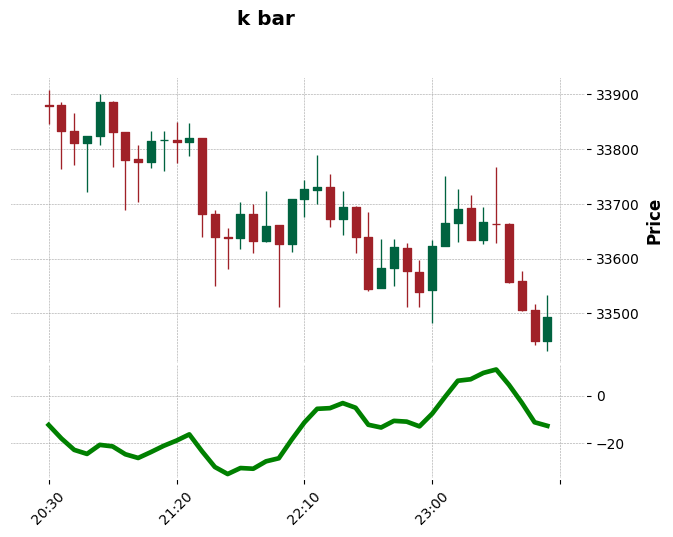

In [24]:
while True:

  df = get_random_count_values_dataframe(dataframe)
  data = df['macdhist'].values.tolist()

  isfind, l = find_peak_sequence_logn_wrapper(data)

  if isfind:
    is_close_low_ema = df['close'].values.tolist()[-1] < (1-0.005) * df['ema100'].values.tolist()[-1]
    is_close_low_bb = (dataframe['close'].values.tolist()[-1] < (1-0.005) * dataframe['bb_lowerband']).values.tolist()[-1]
    is_low_decreasing = df['is_low_decreasing'].values.tolist()[-1]
    print(is_close_low_ema, is_close_low_bb, is_low_decreasing)
    if is_low_decreasing and is_close_low_ema:
      print(data)
      print(l)
      df.set_index('date', inplace=True)

      # 建立一個 MACD histogram 的圖像
      ap = mpf.make_addplot(df['macdhist'], panel=1, color='g', secondary_y=False)

      # 繪製 K 線圖，並添加 MACD histogram
      mpf.plot(df, type='candle', style='charles', title='k bar', addplot=ap)

      # 顯示圖表
      plt.show()

      break